## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
import pickle
with open('/content/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

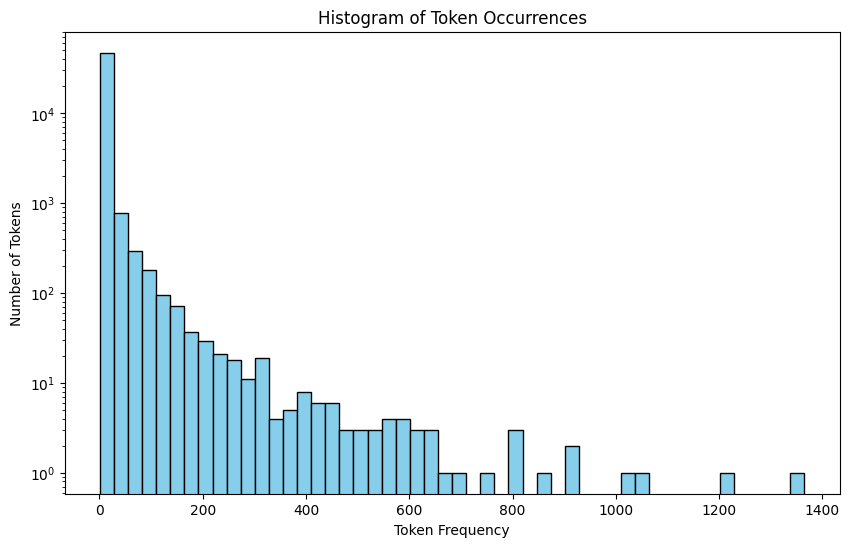

Top 10 most common tokens:
new: 1365
date: 1202
get: 1052
please: 1022
enron: 927
like: 923
2002: 869
would: 806
one: 798
message: 795


In [2]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(token_count.values(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Token Occurrences')
plt.xlabel('Token Frequency')
plt.ylabel('Number of Tokens')
plt.yscale('log')
plt.show()

# Print the 10 most common tokens
print("Top 10 most common tokens:")
for word, freq in token_freq[:10]:
    print(f"{word}: {freq}")

The frequency distribution is highly skewed. A few tokens appear very frequently, while most occur only a few times.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_parquet("/content/Phishing_clean.parquet")

y = df["Email Type"].astype(int)
X = df.drop(columns=["Email Type"])

# 80/20 train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Regression of y on the one-hot-encoded emails
ols = LinearRegression().fit(X_train, y_train)
r2_train = ols.score(X_train, y_train)
r2_test  = ols.score(X_test, y_test)
print(f"R^2 train: {r2_train:.4f}\nR^2 test : {r2_test:.4f}")

# Coefficients
coefs = pd.Series(ols.coef_, index=X.columns)
print("\nTop 20 by |coefficient|:")
print(coefs.reindex(coefs.abs().sort_values(ascending=False).index).head(20))

print("\nTop 10 positive:")
print(coefs.sort_values(ascending=False).head(10)) # pushes toward scam=1

print("\nTop 10 negative:")
print(coefs.sort_values().head(10)) # pushes toward non-scam=0


R^2 train: 0.7713
R^2 test : 0.6424

Top 20 by |coefficient|:
background-image:   -1.016799
localized            0.839522
thermal              0.699684
#000000;             0.615728
#331f30;             0.615728
form.                0.593718
aging                0.586465
erectile             0.538953
girlfriend           0.527557
xanaax               0.516449
cnet                -0.503287
zdnet               -0.449120
para                 0.415604
fax,                 0.407003
exercise!            0.402741
lotto                0.401747
url:                -0.398490
excelled             0.398307
transcript           0.393594
ï¿½ï¿½               0.391521
dtype: float64

Top 10 positive:
localized     0.839522
thermal       0.699684
#000000;      0.615728
#331f30;      0.615728
form.         0.593718
aging         0.586465
erectile      0.538953
girlfriend    0.527557
xanaax        0.516449
para          0.415604
dtype: float64

Top 10 negative:
background-image:   -1.016799
cnet        

The model explains about 77.13% of the variation in the training data and around 64.24% in the test data, which means it performs well overall and does not overfit too much. The words with the biggest influence on predicting whether an email is a scam include “localized,” “thermal,” “#000000,” “form,” “aging,” “erectile,” “girlfriend,” and “xanaax.” These are often found in spam or promotional messages. On the other hand, words like “background-image,” “cnet,” “zdnet,” “url,” and “yahoo!” are linked to legitimate emails and reduce the chance of being labeled as scams. Therefore, spam-related or suspicious words push the model toward predicting an email as a scam, while technical or common website terms suggest it is a normal message.

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

Explained variance ratio: PC1=0.0111, PC2=0.0086, Total (PC1+PC2)=0.0197


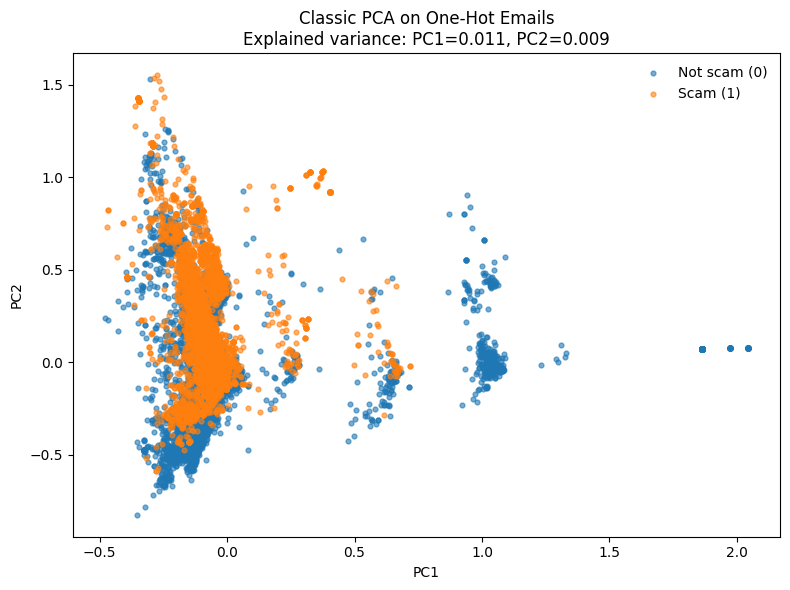


Top tokens by |loading| on PC1:
date         0.674001
url:         0.367372
start        0.287398
hour         0.260598
hourahead    0.255699
ancillary    0.194727
schedules    0.194366
please      -0.109152
would       -0.089897
like        -0.089769
get         -0.067636
required     0.063312
schedule     0.062767
failure      0.062334
crawler      0.062223
Name: PC1, dtype: float64

Top tokens by |loading| on PC2:
new           0.453409
like          0.411642
get           0.320057
would         0.316349
please       -0.208177
message      -0.147064
hello         0.144789
offer         0.138349
software      0.131809
attached     -0.130740
call         -0.126262
one           0.109740
enron        -0.108452
conference   -0.096096
original     -0.092445
Name: PC2, dtype: float64


In [8]:
import numpy as np
from sklearn.decomposition import PCA

feature_names = X.columns
X_dense = X.values.astype(float)
X_centered = X_dense - X_dense.mean(axis=0, keepdims=True)

# Fit PCA with 2 components
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_centered)
pc1, pc2 = Z[:, 0], Z[:, 1]
evr = pca.explained_variance_ratio_

print(f"Explained variance ratio: PC1={evr[0]:.4f}, PC2={evr[1]:.4f}, "
      f"Total (PC1+PC2)={evr[:2].sum():.4f}")

# Scatter plot
plt.figure(figsize=(8, 6))
mask0 = (y == 0)
mask1 = (y == 1)

plt.scatter(pc1[mask0], pc2[mask0], s=12, alpha=0.6, label="Not scam (0)")
plt.scatter(pc1[mask1], pc2[mask1], s=12, alpha=0.6, label="Scam (1)")

plt.title(
    f"Classic PCA on One-Hot Emails\nExplained variance: "
    f"PC1={evr[0]:.3f}, PC2={evr[1]:.3f}"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Inspect token loadings
loadings = pd.DataFrame(
    pca.components_.T, index=feature_names, columns=["PC1", "PC2"]
)
top_k = 15

top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(top_k).index
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(top_k).index

print("\nTop tokens by |loading| on PC1:")
print(loadings.loc[top_pc1, "PC1"].sort_values(key=np.abs, ascending=False))

print("\nTop tokens by |loading| on PC2:")
print(loadings.loc[top_pc2, "PC2"].sort_values(key=np.abs, ascending=False))


The first two principal components explain only about 2% of the total variance, so most of the information in the emails is spread across many other dimensions. In the scatter plot, scamming and non-scamming emails overlap a lot, but there is still some partial separation. Scam emails tend to cluster more toward the center, while non-scam emails are spread out. The top words influencing these components include common scheduling terms like “date,” “hour,” and “schedule,” and frequent communication words like “please,” “like,” and “get.” This suggests that differences in word usage patterns, such as time-related or polite language, help distinguish between scam and non-scam emails, though the boundary is not very clear.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [11]:
# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_dense, y, test_size=0.2, random_state=42, stratify=y
)

# Mean-center
mu = X_tr.mean(axis=0, keepdims=True)
X_tr_c = X_tr - mu
X_te_c = X_te - mu

# PCA with 2,610 components
pca = PCA(n_components=2610, random_state=42)
Z_tr = pca.fit_transform(X_tr_c)
Z_te = pca.transform(X_te_c)

print(f"Cumulative explained variance (first 2610 PCs): "
      f"{pca.explained_variance_ratio_.sum():.4f}")

# OLS on PCA features
ols_pca = LinearRegression()
ols_pca.fit(Z_tr, y_tr)

r2_pca_tr = ols_pca.score(Z_tr, y_tr)
r2_pca_te = ols_pca.score(Z_te, y_te)

print(f"R^2 with PCA features (train): {r2_pca_tr:.4f}")
print(f"R^2 with PCA features (test) : {r2_pca_te:.4f}")

print("Comparison with baseline OLS:")
print(f"Train: {r2_pca_tr - r2_train:+.4f}")
print(f"Test : {r2_pca_te - r2_test:+.4f}")

Cumulative explained variance (first 2610 PCs): 0.9999
R^2 with PCA features (train): 0.7707
R^2 with PCA features (test) : 0.6450
Comparison with baseline OLS:
Train: -0.0006
Test : +0.0026


The PCA with 2,610 components captures almost all of the dataset’s variance (99.99%). This means the model loses very little information. The training R^2 is 0.7707, and the testing R^2 is 0.6450. These values are almost the same as those from the baseline linear regression without PCA. Linear regression already handles multicollinearity well, so PCA does not add much benefit. The results show that PCA does not meaningfully change model performance. It slightly reduces training accuracy but slightly improves testing accuracy.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components makes the model simpler and more stable. The original data has thousands of word columns that are often related to each other, which can confuse the model and cause overfitting. PCA combines these columns into a smaller number of new features. Each new feature captures the most important patterns in the data. These new features are not correlated with each other, which helps the model run faster and make more reliable predictions.